# Discharge Notes and Readmission Rates: Additional Features

In this notebook, I took the text data that has been processed through NLP and merged with other patient data features and ran the data through models to see if if I can get better scores than just with the text data. 

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

## Functions

In [2]:
def scores(model, X, y, set_type):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    acc_score = accuracy_score(y, pred)
    rec_score = recall_score(y, pred)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", acc_score)
    print("recall:   ", rec_score)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    return round(acc_score*100,1), round(rec_score*100,1) 

## Reading in the Data

Here, I read in the dataset with the NLP processed text data and the other patient data features. The first dataframe (df1) is with the predicted classification (0 no readmission or 1 readmission) in the TEXT column. The second dataframe (df1) is with the predicted probabilities of classes in the TEXT column.

In [3]:
df1 = pd.read_csv("data/admissions_nlp_processed_1.csv.gz", compression='gzip')

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      52726 non-null  object
 1   ADMISSION_LOCATION  52726 non-null  object
 2   DISCHARGE_LOCATION  52726 non-null  object
 3   INSURANCE           52726 non-null  object
 4   LANGUAGE            52726 non-null  object
 5   RELIGION            52726 non-null  object
 6   MARITAL_STATUS      52726 non-null  object
 7   ETHNICITY           52726 non-null  object
 8   DIAGNOSIS           52726 non-null  object
 9   READMISSION         52726 non-null  int64 
 10  GENDER              52726 non-null  object
 11  AGE                 52726 non-null  int64 
 12  CPT_CD              52726 non-null  object
 13  DIAG_ICD9_CODE      52722 non-null  object
 14  DRG_CODE            52726 non-null  object
 15  PROCED_ICD9_CODE    52726 non-null  object
 16  TEXT                52

In [5]:
#originally had planned to break codes out, but the models were running too long, therefore had to drop code columns
df1.drop(['DIAG_ICD9_CODE','DRG_CODE', 'PROCED_ICD9_CODE'], axis=1, inplace=True)

In [6]:
df1['TEXT'].head()

0    1
1    0
2    0
3    0
4    1
Name: TEXT, dtype: int64

In [7]:
#set X as the text data, and y as the readmission status
X1 = df1.drop('READMISSION', axis=1)
y1 = df1['READMISSION']

In [8]:
df2 = pd.read_csv("data/admissions_nlp_processed_2.csv.gz", compression='gzip')

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ADMISSION_TYPE      52726 non-null  object 
 1   ADMISSION_LOCATION  52726 non-null  object 
 2   DISCHARGE_LOCATION  52726 non-null  object 
 3   INSURANCE           52726 non-null  object 
 4   LANGUAGE            52726 non-null  object 
 5   RELIGION            52726 non-null  object 
 6   MARITAL_STATUS      52726 non-null  object 
 7   ETHNICITY           52726 non-null  object 
 8   DIAGNOSIS           52726 non-null  object 
 9   READMISSION         52726 non-null  int64  
 10  GENDER              52726 non-null  object 
 11  AGE                 52726 non-null  int64  
 12  CPT_CD              52726 non-null  object 
 13  DIAG_ICD9_CODE      52722 non-null  object 
 14  DRG_CODE            52726 non-null  object 
 15  PROCED_ICD9_CODE    52726 non-null  object 
 16  TEXT

In [10]:
#originally had planned to break codes out, but the models were running too long, therefore had to drop code columns
df2.drop(['DIAG_ICD9_CODE','DRG_CODE', 'PROCED_ICD9_CODE'], axis=1, inplace=True)

In [11]:
df2['TEXT'].head()

0    0.551149
1    0.367082
2    0.402644
3    0.282630
4    0.544221
Name: TEXT, dtype: float64

In [12]:
df2['READMISSION'].value_counts()

0    49715
1     3011
Name: READMISSION, dtype: int64

In [13]:
#set X as the text data, and y as the readmission status
X2 = df2.drop('READMISSION', axis=1)
y2 = df2['READMISSION']

## Train, Validation, and Test Split

Here I split both dataframes into train, validation, and test sets.

In [14]:
X_train1, X_v_t1, y_train1, y_v_t1 = train_test_split(X1, y1, test_size=0.30, random_state=42, stratify=y1)

In [15]:
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_v_t1, y_v_t1, test_size=0.50, random_state=42, stratify=y_v_t1)

In [16]:
X_train1.shape

(36908, 13)

In [17]:
X_train2, X_v_t2, y_train2, y_v_t2 = train_test_split(X2, y2, test_size=0.30, random_state=42, stratify=y2)

In [18]:
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_v_t2, y_v_t2, test_size=0.50, random_state=42, stratify=y_v_t2)

In [19]:
X_train2.shape

(36908, 13)

## Handling Imbalanced Data 

Just as I had to handle the imbalanced classes in the previous notebook on NLP, I used the undersampling method to mitigate the impacts of the imbalanced classes.

In [20]:
#concat the train dataset together
train_df = pd.concat([y_train1, X_train1], axis=1)

In [21]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [22]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [23]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [24]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [25]:
#split out the X and y of the new dataset
y_train1 = new_train_df['READMISSION']
X_train1 = new_train_df.drop('READMISSION', axis=1)
max_feats_1 = int(X_train1.shape[0]*0.10)

In [26]:
#concat the train dataset together
train_df = pd.concat([y_train2, X_train2], axis=1)

In [27]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [28]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [29]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [30]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [31]:
#split out the X and y of the new dataset
y_train2 = new_train_df['READMISSION']
X_train2 = new_train_df.drop('READMISSION', axis=1)
max_feats_2 = int(X_train2.shape[0]*0.10)

## Pipeline Parameters

In this section, I set specific pipeline parameters that I will keep constant throughout the project.

In [32]:
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4216 entries, 35763 to 6932
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      4216 non-null   object
 1   ADMISSION_LOCATION  4216 non-null   object
 2   DISCHARGE_LOCATION  4216 non-null   object
 3   INSURANCE           4216 non-null   object
 4   LANGUAGE            4216 non-null   object
 5   RELIGION            4216 non-null   object
 6   MARITAL_STATUS      4216 non-null   object
 7   ETHNICITY           4216 non-null   object
 8   DIAGNOSIS           4216 non-null   object
 9   GENDER              4216 non-null   object
 10  AGE                 4216 non-null   int64 
 11  CPT_CD              4216 non-null   object
 12  TEXT                4216 non-null   int64 
dtypes: int64(2), object(11)
memory usage: 461.1+ KB


In [33]:
X_num = ['AGE']
X_cat = df1.drop(['AGE', 'READMISSION'], axis=1).columns

In [34]:
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'))
    ])

c_transform = ColumnTransformer(transformers=[
    ('num', numTrans, X_num),
    ('cat', catTrans, X_cat)
    ])

## Modeling

### Model 0: Dummy Classification

In [35]:
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    #('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")) 
    ])

Train Scores
accuracy:  0.5026091081593927
recall:    0.5009487666034156
Validation Scores
accuracy:  0.4965229485396384
recall:    0.5176991150442478
Test Scores
accuracy:  0.49235048678720444
recall:    0.4811529933481153


(49.2, 48.1)

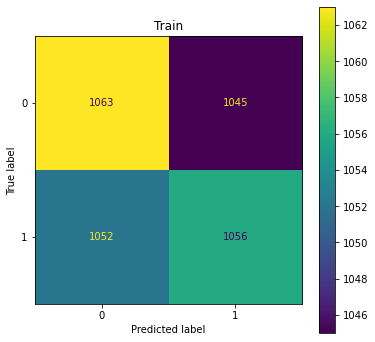

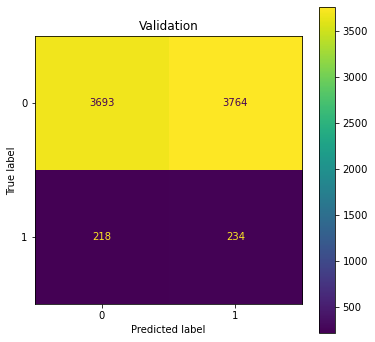

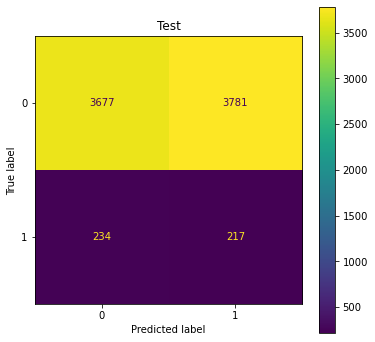

In [36]:
pp1.fit(X_train1, y_train1)

scores(pp1, X_train1, y_train1, 'Train')
scores(pp1, X_val1, y_val1, 'Validation')
scores(pp1, X_test1, y_test1, 'Test')

In [37]:
pp2 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")) 
    ])

Train Scores
accuracy:  0.5026091081593927
recall:    0.5009487666034156
Validation Scores
accuracy:  0.4965229485396384
recall:    0.5176991150442478
Test Scores
accuracy:  0.49235048678720444
recall:    0.4811529933481153


(49.2, 48.1)

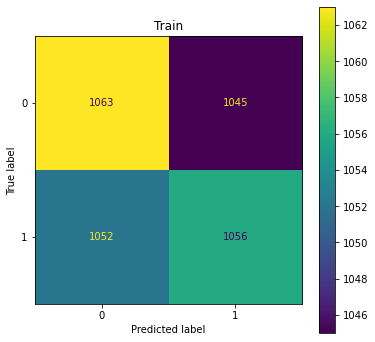

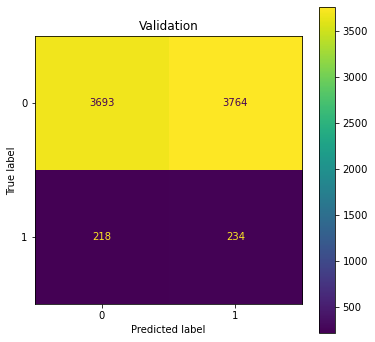

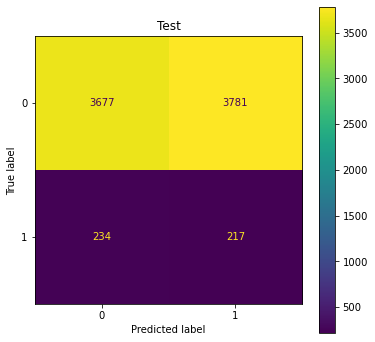

In [38]:
pp2.fit(X_train2, y_train2)

scores(pp1, X_train2, y_train2, 'Train')
scores(pp1, X_val2, y_val2, 'Validation')
scores(pp1, X_test2, y_test2, 'Test')

### Model 1: Logistic Regression

In [39]:
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('logreg', LogisticRegression(random_state=42)) 
    ])

Train Scores
accuracy:  0.7217741935483871
recall:    0.7590132827324478
Validation Scores
accuracy:  0.6405360981160703
recall:    0.7190265486725663
Test Scores
accuracy:  0.6386395245922367
recall:    0.7161862527716186


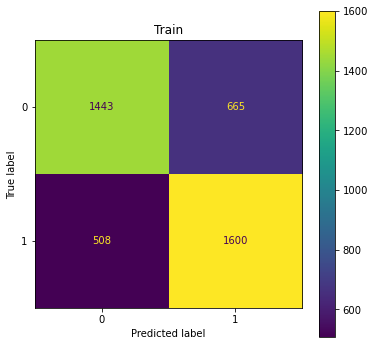

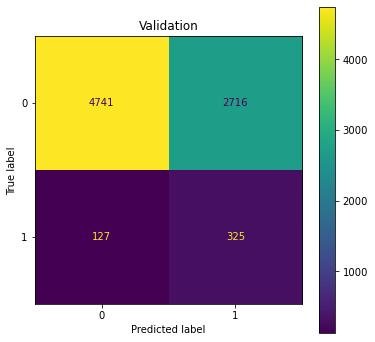

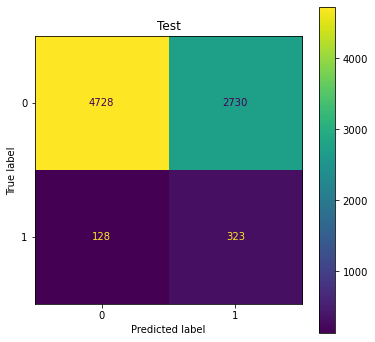

In [40]:
pp1.fit(X_train1, y_train1)

scores(pp1, X_train1, y_train1, 'Train')
scores(pp1, X_val1, y_val1, 'Validation')
log_acc, log_recall = scores(pp1, X_test1, y_test1, 'Test')

In [41]:
pp2 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_2, random_state=42)),
    ('logreg', LogisticRegression(random_state=42)) 
    ])

Train Scores
accuracy:  0.7106261859582542
recall:    0.7509487666034156
Validation Scores
accuracy:  0.5945125806043747
recall:    0.7123893805309734
Test Scores
accuracy:  0.6093058540902769
recall:    0.6873614190687362


(60.9, 68.7)

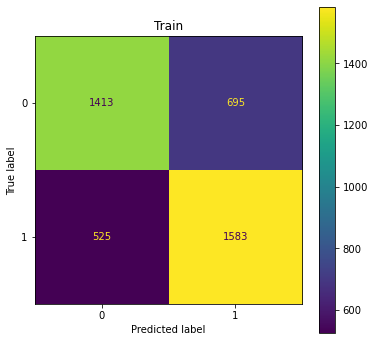

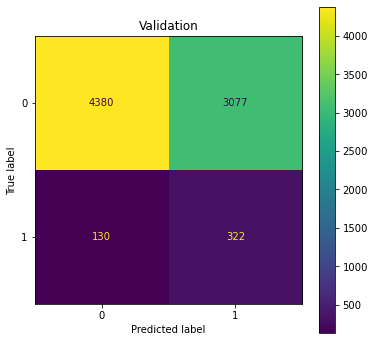

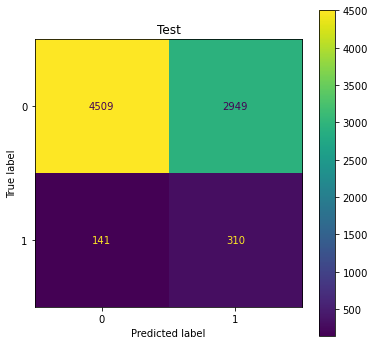

In [42]:
pp2.fit(X_train2, y_train2)

scores(pp2, X_train2, y_train2, 'Train')
scores(pp2, X_val2, y_val2, 'Validation')
scores(pp2, X_test2, y_test2, 'Test')

The dataframe with the predicted classification had better scores than the dataframe with the predicted probabilities. Therefore, going forward, I will use just dataframe one, the dataframe with predicted classification.

### Model 2: Gaussian Naive Bayes

In [43]:
pp_gnb = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('gnb', GaussianNB()) 
    ])

Train Scores
accuracy:  0.6359108159392789
recall:    0.6935483870967742
Validation Scores
accuracy:  0.5168795043621192
recall:    0.6880530973451328
Test Scores
accuracy:  0.5134656720192187
recall:    0.6718403547671841


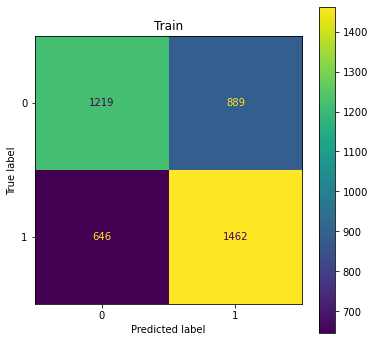

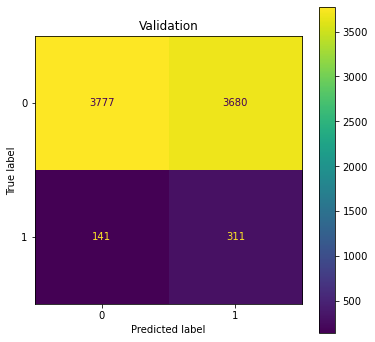

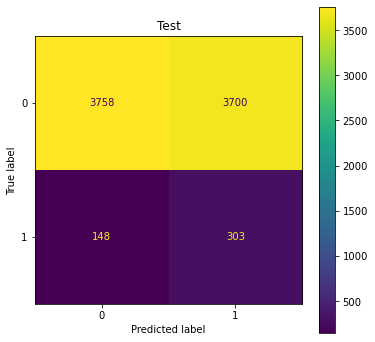

In [44]:
pp_gnb.fit(X_train1, y_train1)

scores(pp_gnb, X_train1, y_train1, 'Train')
scores(pp_gnb, X_val1, y_val1, 'Validation')
gnb_acc, gnb_recall = scores(pp_gnb, X_test1, y_test1, 'Test')

### Model 3: Random Forest

In [45]:
pp_rf = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)) 
    ])

In [46]:
grid = {'rf__max_depth': [3,5,8,10],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [2, 5, 10],
        'rf__min_samples_split': [2, 5, 7]}

In [47]:
# gs_rf = GridSearchCV(estimator=pp_rf, 
#                       param_grid=grid, 
#                       scoring='recall', 
#                       cv=3,
#                       verbose=2,
#                       n_jobs=-1
#                      )

In [48]:
# gs_rf.fit(X_train1, y_train1)

# scores(gs_rf, X_train1, y_train1, 'Train')
# scores(gs_rf, X_val1, y_val1, 'Validation')
# rf_acc, rf_recall = scores(gs_rf, X_test1, y_test1, 'Test')

In [49]:
# gs_rf.best_params_

In [50]:
"""
{'rf__max_depth': 5,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 10,
 'rf__min_samples_split': 2}
"""

"\n{'rf__max_depth': 5,\n 'rf__max_features': 'auto',\n 'rf__min_samples_leaf': 10,\n 'rf__min_samples_split': 2}\n"

In [51]:
pp_rf = Pipeline(steps=[('c_trans', c_transform),
                        ('pca', PCA(n_components=max_feats_1, random_state=42)),
                        ('rf', RandomForestClassifier(random_state=42,
                                                      max_depth=5,
                                                      max_features='auto',
                                                      min_samples_leaf=10,
                                                      min_samples_split=2)) 
    ])

Train Scores
accuracy:  0.7730075901328273
recall:    0.8287476280834914
Validation Scores
accuracy:  0.6176507775951448
recall:    0.6969026548672567
Test Scores
accuracy:  0.6318118599064357
recall:    0.7649667405764967


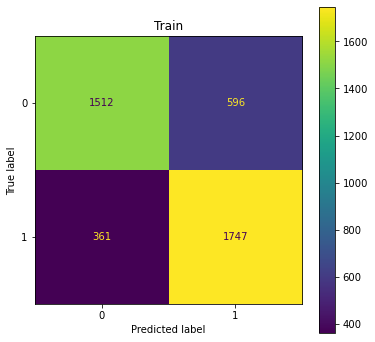

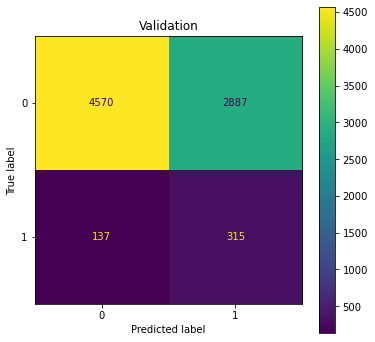

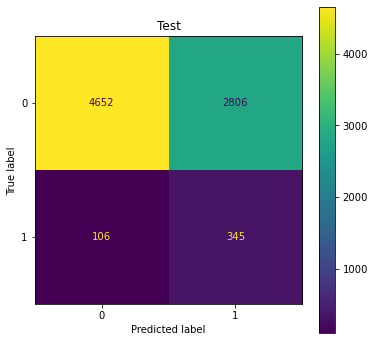

In [52]:
pp_rf.fit(X_train1, y_train1)

scores(pp_rf, X_train1, y_train1, 'Train')
scores(pp_rf, X_val1, y_val1, 'Validation')
rf_acc, rf_recall = scores(pp_rf, X_test1, y_test1, 'Test')

Train Scores
accuracy:  0.7730075901328273
recall:    0.8287476280834914
Validation Scores
accuracy:  0.6176507775951448
recall:    0.6969026548672567
Test Scores
accuracy:  0.6318118599064357
recall:    0.7649667405764967

### Model 4: K-Nearest Neighbors

In [53]:
pp_knn = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('knn', KNeighborsClassifier())  
    ])

In [54]:
grid = {'knn__n_neighbors': list(range(3, 20, 2)),
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1, 2, 3, 4]}

In [55]:
# gs_knn = GridSearchCV(estimator=pp_knn, 
#                       param_grid=grid, 
#                       scoring='recall', 
#                       cv=3,
#                       verbose=2,
#                       n_jobs=-1
#                      )

In [56]:
# gs_knn.fit(X_train1, y_train1)

# scores(gs_knn, X_train1, y_train1, 'Train')
# scores(gs_knn, X_val1, y_val1, 'Validation')
# knn_acc, knn_recall = scores(gs_knn, X_test1, y_test1, 'Test')

In [57]:
# gs_knn.best_params_

In [58]:
"""
{'knn__n_neighbors': 17, 'knn__p': 1, 'knn__weights': 'distance'}
"""

"\n{'knn__n_neighbors': 17, 'knn__p': 1, 'knn__weights': 'distance'}\n"

In [59]:
pp_knn = Pipeline(steps=[('c_trans', c_transform),
                         ('pca', PCA(n_components=max_feats_1, random_state=42)),
                         ('knn', KNeighborsClassifier(n_neighbors=21,
                                                      p=1,
                                                      weights='uniform')) #adjusting the weights to uniform instead of distance helped with the overfitting 
     ])

Train Scores
accuracy:  0.6987666034155597
recall:    0.7694497153700189
Validation Scores
accuracy:  0.5854090276899735
recall:    0.7323008849557522
Test Scores
accuracy:  0.5940068276646858
recall:    0.720620842572062


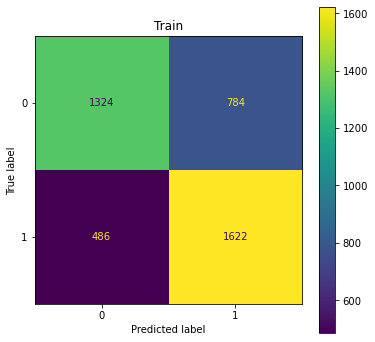

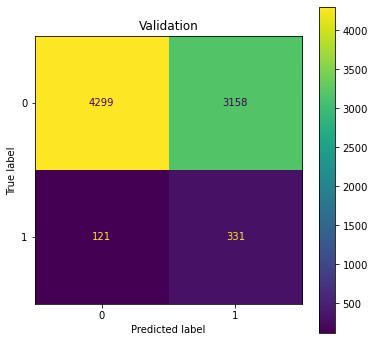

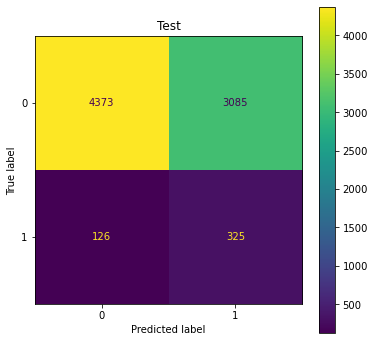

In [60]:
pp_knn.fit(X_train1, y_train1)

scores(pp_knn, X_train1, y_train1, 'Train')
scores(pp_knn, X_val1, y_val1, 'Validation')
knn_acc, knn_recall = scores(pp_knn, X_test1, y_test1, 'Test')

### Model 5: Decision Tree Model

In [61]:
pp_dt = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))  
    ])

In [62]:
grid = {'dt__criterion': ['gini', 'entropy'],
        'dt__max_depth': np.arange(1,17, 3),
        'dt__min_samples_split': np.arange(20, 101, 10),
        'dt__min_samples_leaf': np.arange(20, 101,10)
       }

In [63]:
# gs_dt = GridSearchCV(estimator=pp_dt, 
#                       param_grid=grid, 
#                       scoring='f1', #setting the scoring to f1 resulted in better scores
#                       cv=3,
#                       verbose=2,
#                       n_jobs=-1
#                      )

In [64]:
# gs_dt.fit(X_train1, y_train1)

# scores(gs_dt, X_train1, y_train1, 'Train')
# scores(gs_dt, X_val1, y_val1, 'Validation')
# dt_acc, dt_recall = scores(gs_dt, X_test1, y_test1, 'Test')

In [65]:
# gs_dt.best_params_

In [66]:
"""
{'dt__criterion': 'entropy',
 'dt__max_depth': 4,
 'dt__min_samples_leaf': 20,
 'dt__min_samples_split': 60}
"""

"\n{'dt__criterion': 'entropy',\n 'dt__max_depth': 4,\n 'dt__min_samples_leaf': 20,\n 'dt__min_samples_split': 60}\n"

In [67]:
pp_dt = Pipeline(steps=[('c_trans', c_transform),
                        ('pca', PCA(n_components=max_feats_1, random_state=42)),
                        ('dt', DecisionTreeClassifier(random_state=42,
                                                      criterion='entropy',
                                                      max_depth=4,
                                                      min_samples_leaf=20,
                                                      min_samples_split=60)) 
    ])

Train Scores
accuracy:  0.6686432637571158
recall:    0.8111954459203036
Validation Scores
accuracy:  0.5200404602351751
recall:    0.7787610619469026
Test Scores
accuracy:  0.5296497660892654
recall:    0.7716186252771619


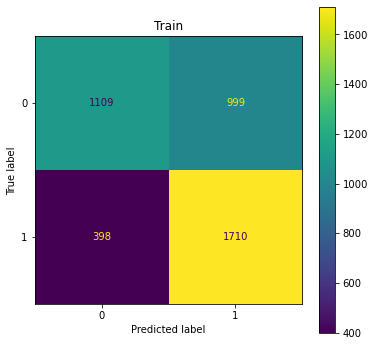

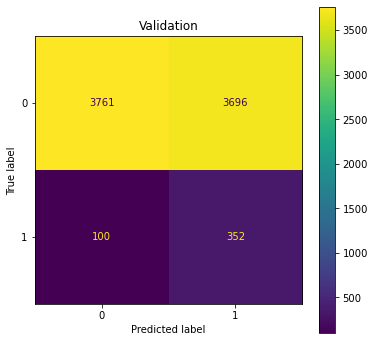

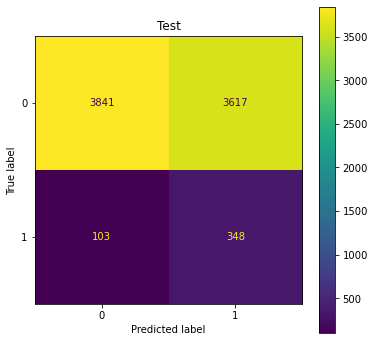

In [68]:
pp_dt.fit(X_train1, y_train1)

scores(pp_dt, X_train1, y_train1, 'Train')
scores(pp_dt, X_val1, y_val1, 'Validation')
dt_acc, dt_recall = scores(pp_dt, X_test1, y_test1, 'Test')

### Model 6: Gradient Boost

In [69]:
pp1 = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=int(0.1*max_feats_1), random_state=42)), #reduce overfitting by passing less features
    ('gbc', GradientBoostingClassifier(random_state=42))  
    ])

In [70]:
grid = {'gbc__max_features': ['auto','log2'],
        'gbc__min_samples_split':[10, 50, 100, 1000],
        'gbc__max_depth':[3, 5, 10, 20]
       }

In [71]:
# gs_gbc = GridSearchCV(estimator=pp1, 
#                       param_grid=grid, 
#                       scoring='recall', 
#                       cv=3,
#                       verbose=2,
#                       n_jobs=-1
#                      )

In [72]:
# gs_gbc.fit(X_train1, y_train1)

# scores(gs_gbc, X_train1, y_train1, 'Train')
# scores(gs_gbc, X_val1, y_val1, 'Validation')
# gbc_acc, gbc_recall = scores(gs_gbc, X_test1, y_test1, 'Test')

In [73]:
# gs_gbc.best_params_

In [74]:
"""
{'gbc__max_depth': 3,
 'gbc__max_features': 'auto',
 'gbc__min_samples_split': 1000
"""

"\n{'gbc__max_depth': 3,\n 'gbc__max_features': 'auto',\n 'gbc__min_samples_split': 1000\n"

In [75]:
pp_gbc = Pipeline(steps=[('c_trans', c_transform),
                         ('pca', PCA(n_components=int(0.1*max_feats_1), random_state=42)),
                         ('gbc', GradientBoostingClassifier(random_state=42,
                                                            max_depth=3,
                                                            max_features='auto',
                                                            min_samples_split=10))
    ])

Train Scores
accuracy:  0.7533206831119544
recall:    0.7917457305502846
Validation Scores
accuracy:  0.6387659628271589
recall:    0.6836283185840708
Test Scores
accuracy:  0.6464786951574156
recall:    0.7317073170731707


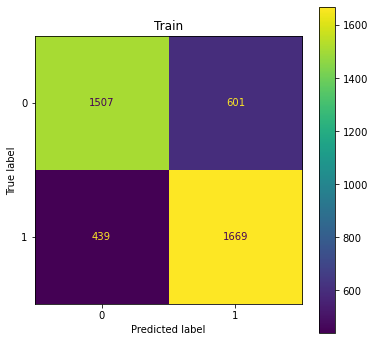

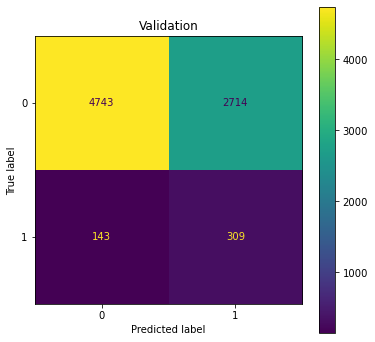

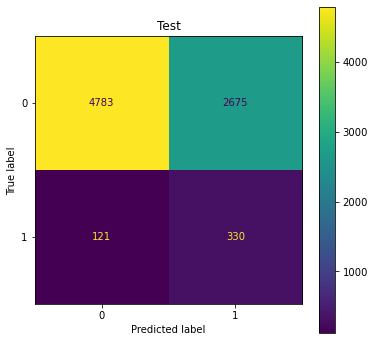

In [76]:
pp_gbc.fit(X_train1, y_train1)

scores(pp_gbc, X_train1, y_train1, 'Train')
scores(pp_gbc, X_val1, y_val1, 'Validation')
gbc_acc, gbc_recall = scores(pp_gbc, X_test1, y_test1, 'Test')

### Model 7: Ensemble

In [77]:
pp_logreg = Pipeline(steps=[
    ('c_trans', c_transform),
    ('pca', PCA(n_components=max_feats_1, random_state=42)),
    ('logreg', LogisticRegression(random_state=42))  
    ])

In [78]:
voting_clf = VotingClassifier(estimators={("logreg", pp_logreg),
                                          #("gnb", pp_gnb),
                                          ("rf", pp_rf),
                                          ('knn', pp_knn),
                                          #('dt', pp_dt),
                                          ("gbc", pp_gbc)
                                        },
                              voting= "soft")

Train Scores
accuracy:  0.7476280834914611
recall:    0.7979127134724858
Validation Scores
accuracy:  0.6363636363636364
recall:    0.7168141592920354
Test Scores
accuracy:  0.6425591098748261
recall:    0.7494456762749445


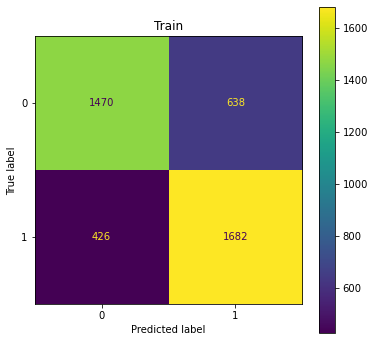

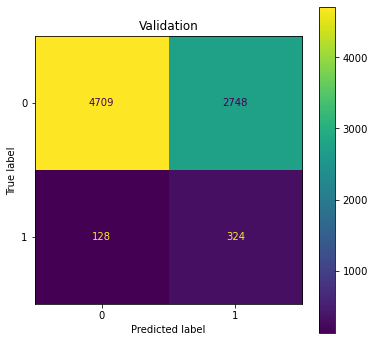

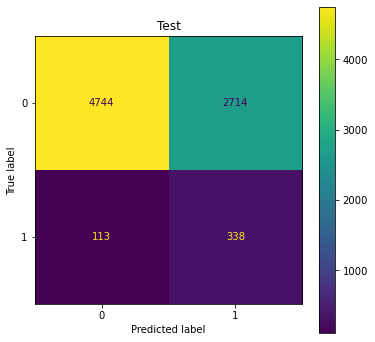

In [79]:
voting_clf.fit(X_train1, y_train1)

scores(voting_clf, X_train1, y_train1, 'Train')
scores(voting_clf, X_val1, y_val1, 'Validation')
vot_acc, vot_recall = scores(voting_clf, X_test1, y_test1, 'Test')

## Reviewing All Models:

In [80]:
X_labels = ['Text Model','Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']
y1 = [70.1, log_recall, gnb_recall, rf_recall, knn_recall, dt_recall, gbc_recall, vot_recall]

In [81]:
y2 = [62.2, log_acc, gnb_acc, rf_acc, knn_acc, dt_acc, gbc_acc, vot_acc]

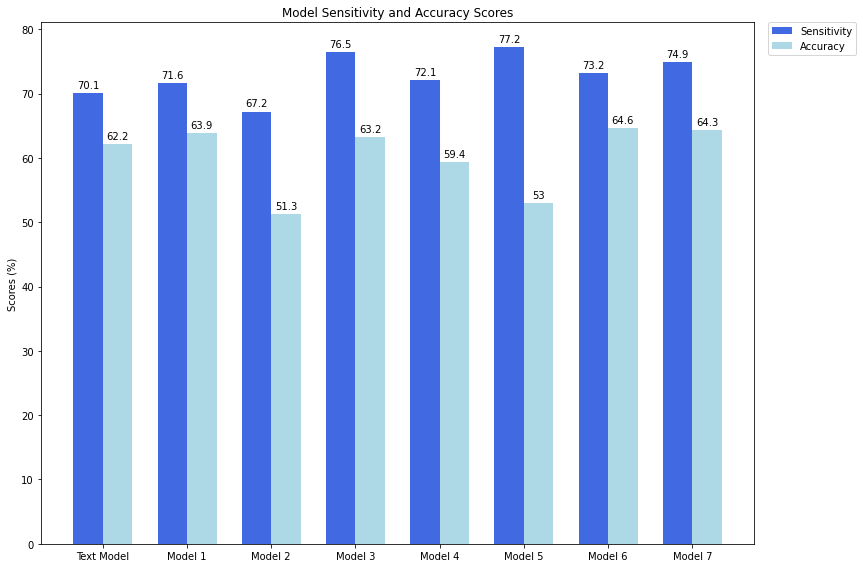

In [82]:
width = 0.35  # the width of the bars
x = np.arange(len(X_labels))
fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, y1, width, label='Sensitivity', color='royalblue')
rects2 = ax.bar(x + width/2, y2, width, label='Accuracy', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores (%)')
ax.set_title('Model Sensitivity and Accuracy Scores')
ax.set_xticks(x)
ax.set_xticklabels(X_labels)
ax.legend(bbox_to_anchor=(1.15, 1.01))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()
#save the figure in the images folder
fig.savefig('images/Model_Scores2.png', bbox_inches='tight')

## Setting Final Model

In [83]:
#split the positive and negative data
df_pos = df1[df1['READMISSION']==1]
df_neg = df1[df1['READMISSION']==0]

In [84]:
#take a sample of the negative training set with the same number of rows as positive dataset
df_neg_samp = df_neg.sample(n=len(df_pos), random_state=42)

In [85]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_df = pd.concat([df_pos,df_neg_samp],axis=0)

In [86]:
#randomize the new dataset
new_df = new_df.sample(n=len(new_df), random_state=42)

In [87]:
#split out the X and y of the new dataset
new_y = new_df['READMISSION']
new_X = new_df.drop('READMISSION',axis=1)
new_max_feats = int(new_X.shape[0]*0.10)

In [88]:
final_model = voting_clf

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Final Scores
accuracy:  0.7334772500830289
recall:    0.7907671869810694


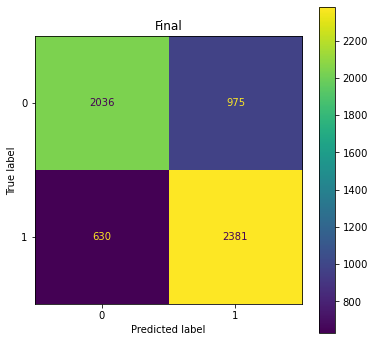

In [91]:
final_model.fit(new_X, new_y)
final_acc, final_recall = scores(final_model, new_X, new_y, 'Final')